In [ ]:
import polars as pl

# ── FILE PATHS ───────────────────────────────────────────────────────────────
input_path = "playerLogs_game2_playerbasedlines.jsonl"
train_path = "train_game2.jsonl"
eval_path  = "eval_game2.jsonl"

# ── LOAD JSONL ────────────────────────────────────────────────────────────────
df = pl.read_ndjson(input_path)

# shuffling rows
# sample exactly df.height rows, i.e. a full shuffle
df_shuffled = df.sample(n=df.height, shuffle=True, seed=42)

# Splitting to 8-20
n_total = df_shuffled.height
n_eval  = int(0.2 * n_total)

df_eval  = df_shuffled[:n_eval]
df_train = df_shuffled[n_eval:]

# Writing Files as Json
df_train.write_ndjson(train_path)
df_eval.write_ndjson(eval_path)

print(f"✅ Done. Train: {df_train.height} | Eval: {df_eval.height}")


^Optional using polars library to split. the one below is fine but takes longer

In [2]:
import random
import json

# 1. File paths
input_path  = 'playerLogs_game2_playerbasedlines.jsonl'   # your full dataset
train_path  = 'train_game2.jsonl'
eval_path   = 'eval_game2.jsonl'

# 2. Read all entries
with open(input_path, 'r', encoding='utf-8') as f:
    entries = [json.loads(line) for line in f]

# 3. Shuffle with a fixed seed
random.seed(40)
random.shuffle(entries)

# 4. Split 80/20
n_total  = len(entries)
n_eval   = int(0.2 * n_total)
eval_set = entries[:n_eval]
train_set= entries[n_eval:]

# 5. Write out the two JSONL files
for path, subset in [(train_path, train_set), (eval_path, eval_set)]:
    with open(path, 'w', encoding='utf-8') as f:
        for obj in subset:
            f.write(json.dumps(obj) + '\n')

print(f"Total players: {n_total}")
print(f" → Training : {len(train_set)}")
print(f" → Evaluation: {len(eval_set)}")


Total players: 79436
 → Training : 63549
 → Evaluation: 15887


In [9]:
import json
import pandas as pd
import numpy as np  # for numpy operations

# ── PARAMETERS ───────────────────────────────────────────────────────────────
OP_DAYS  = 5
CP_DAYS  = 10
S_IN_DAY = 24 * 60 * 60
OP_S     = OP_DAYS * S_IN_DAY
CP_S     = CP_DAYS * S_IN_DAY

def collect_events(records):
    """
    Return two lists of all valid events:
     - all_plays    : [(time, queueDuration, action, fail_state, reward), ...]
     - all_buys     : [(time, queueDuration, price), ...]
    """
    all_plays = []
    all_buys  = []
    for r in records:
        ev    = r.get("event")
        t     = r.get("time")
        qd    = r.get("queueDuration")
        props = r.get("properties") or {}

        if ev == "progress" and t is not None and qd is not None:
            reward = props.get("reward")
            action = props.get("action")
            fs     = props.get("fail_state")
            all_plays.append((t, float(qd), action, fs,
                              float(reward) if reward is not None else None))

        elif ev == "softPurchase" and t is not None and qd is not None:
            price = props.get("price")
            if price is not None:
                all_buys.append((t, float(qd), float(price)))

    all_plays.sort(key=lambda x: x[0])
    all_buys.sort(key=lambda x: x[0])
    return all_plays, all_buys

def extract_features(input_jsonl: str, output_csv: str):
    rows = []
    with open(input_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            pl = json.loads(line)
            uid = pl.get("uid") or pl.get("device")
            plays, buys = collect_events(pl["records"])

            if not plays:
                continue

            t0 = plays[0][0]
            rel_plays = [(t - t0, qd, action, fs, reward)
                         for (t,qd,action,fs,reward) in plays]
            rel_buys   = [(t - t0, qd, price) for (t,qd,price) in buys]

            obs_plays = [p for p in rel_plays if p[0] <= OP_S]
            pred_plays= [p for p in rel_plays if OP_S < p[0] <= OP_S + CP_S]

            if not obs_plays:
                continue

            play_count        = len(obs_plays)
            active_duration_s = obs_plays[-1][0] if play_count > 1 else 0.0
            churn             = 1 if not pred_plays else 0

            scores = [r for (_,_,_,_,r) in obs_plays if r is not None]
            mean_score          = float(np.mean(scores)) if scores else 0.0
            sd_score            = float(np.std(scores, ddof=0)) if scores else 0.0
            best_score          = float(max(scores)) if scores else 0.0
            worst_score         = float(min(scores)) if scores else 0.0
            best_idx            = scores.index(best_score) if len(scores)>1 else 0
            best_score_index    = best_idx/(len(scores)-1) if len(scores)>1 else 0.0
            best_sub_mean_count = ((best_score-mean_score)/len(scores)
                                   if scores else 0.0)
            best_sub_mean_ratio = ((best_score-mean_score)/mean_score
                                   if mean_score else 0.0)

            gaps = [obs_plays[i+1][0] - obs_plays[i][0]
                    for i in range(play_count-1)]
            consec_count           = sum(1 for g in gaps if g <= 3600)
            consecutive_play_ratio = (consec_count/(play_count-1)
                                      if play_count>1 else 0.0)
            median_gap             = float(np.median(gaps)) if gaps else 0.0

            failure_count = sum(
                1 for (_,_,action,fs,_) in obs_plays
                  if action in ("fail","quit") and fs is not None
            )
            failure_ratio = failure_count/play_count if play_count else 0.0

            qd_list = [qd for (_,qd,_,_,_) in obs_plays] + \
                      [qd for (_,qd,_) in rel_buys]
            avg_queue_duration = float(np.mean(qd_list)) if qd_list else 0.0

            obs_buys = [p for p in rel_buys if p[0] <= OP_S]
            purchase_count = len(obs_buys)
            highest_price  = float(max(p for (_,_,p) in obs_buys)) if obs_buys else 0.0

            # recency of last purchase (seconds since most recent purchase until end of OP)
            if obs_buys:
                last_pur_time = max(t for (t,_,_) in obs_buys)
                recency_last_purchase = OP_S - last_pur_time
            else:
                recency_last_purchase = OP_S

            rows.append({
                "uid": uid,
                "play_count": play_count,
                "active_duration_s": active_duration_s,
                "churn": churn,

                "mean_score": mean_score,
                "sd_score": sd_score,
                "best_score": best_score,
                "worst_score": worst_score,
                "best_score_index": best_score_index,
                "best_sub_mean_count": best_sub_mean_count,
                "best_sub_mean_ratio": best_sub_mean_ratio,

                "consecutive_play_ratio": consecutive_play_ratio,
                "median_gap": median_gap,
                "avg_queue_duration": avg_queue_duration,

                "failure_count": failure_count,
                "failure_ratio": failure_ratio,

                "purchase_count": purchase_count,
                "highest_price": highest_price,
                "recency_last_purchase": recency_last_purchase,
                "purchase_rate" : purchase_count/play_count
            })

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"✅ Wrote {output_csv}, shape = {df.shape}")

# ── RUN FOR BOTH SPLITS ─────────────────────────────────────────────────────────
extract_features("train_game2.jsonl", "DS1_game2.csv")


✅ Wrote DS1_game2.csv, shape = (63549, 20)


In [10]:
import pandas as pd
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from xgboost                 import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib

# ── 1) LOAD DS1 FOR GAME 2 ────────────────────────────────────────────────────
df_train = pd.read_csv('DS1_game2.csv')
X_train  = df_train.drop(['uid','churn'], axis=1)
y_train  = df_train['churn']

# ── 2) HYPERPARAMETER TUNING FOR DECISION TREE ON DS1_game2 ──────────────────
base_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth'        : [None, 5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf' : [1, 5, 10],
    'ccp_alpha'        : [0.0, 0.005, 0.01]
}

grid = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("▶ Best Decision Tree params (game2):", grid.best_params_)
print("▶ Best CV AUC (game2):", grid.best_score_)

# extract tuned tree
tuned_tree = grid.best_estimator_

# ── 3) DEFINE FINAL CLASSIFIERS FOR GAME 2 ───────────────────────────────────
models = {
    'Decision Tree (tuned)' : tuned_tree,
    'Random Forest'         : RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost'               : XGBClassifier(
                                  n_estimators=100,
                                  eval_metric='logloss',
                                  random_state=42
                              ),
    'Logistic Regression'   : LogisticRegression(
                                  max_iter=10000,
                                  solver='lbfgs',
                                  random_state=42
                              )
}

# ── 4) TRAIN ALL MODELS ON FULL DS1_game2 ─────────────────────────────────────
trained_models = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    trained_models[name] = clf
    print(f"✅ Trained: {name}")

# ── 5) SAVE MODELS TO DISK ─────────────────────────────────────────────────────
for name, model in trained_models.items():
    fname = name.lower().replace(' ','_').replace('(tuned)','tuned')
    path  = f"game2_{fname}_model.pkl"
    joblib.dump(model, path)
    print(f"💾 Saved {name} to: {path}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\fhawk\anaconda3\envs\pt\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


▶ Best Decision Tree params (game2): {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
▶ Best CV AUC (game2): 0.8585576424557846
✅ Trained: Decision Tree (tuned)
✅ Trained: Random Forest
✅ Trained: XGBoost
✅ Trained: Logistic Regression
💾 Saved Decision Tree (tuned) to: game2_decision_tree_tuned_model.pkl
💾 Saved Random Forest to: game2_random_forest_model.pkl
💾 Saved XGBoost to: game2_xgboost_model.pkl
💾 Saved Logistic Regression to: game2_logistic_regression_model.pkl


In [11]:
extract_features('eval_game2.jsonl',  'DS2_game2.csv')   # 20% split

✅ Wrote DS2_game2.csv, shape = (15887, 20)


### Performance on DS2_game2 ###
                       Accuracy  Precision(1)  Recall(1)     F1(1)   ROC-AUC
Model                                                                       
Decision Tree (tuned)  0.810474      0.881456   0.787872  0.832041  0.860021
Random Forest          0.808271      0.872476   0.794317  0.831564  0.859051
XGBoost                0.812236      0.865404   0.811008  0.837323  0.867140
Logistic Regression    0.788947      0.842158   0.794739  0.817762  0.842204

### Top 5 Features per Model ###

Decision Tree (tuned):
active_duration_s        0.909130
recency_last_purchase    0.074643
avg_queue_duration       0.006666
best_score_index         0.004614
play_count               0.002705

Random Forest:
active_duration_s        0.264286
recency_last_purchase    0.125303
avg_queue_duration       0.089599
best_sub_mean_ratio      0.055954
median_gap               0.055047

XGBoost:
active_duration_s        0.543830
recency_last_purchase    0.073166
avg_queue_dur

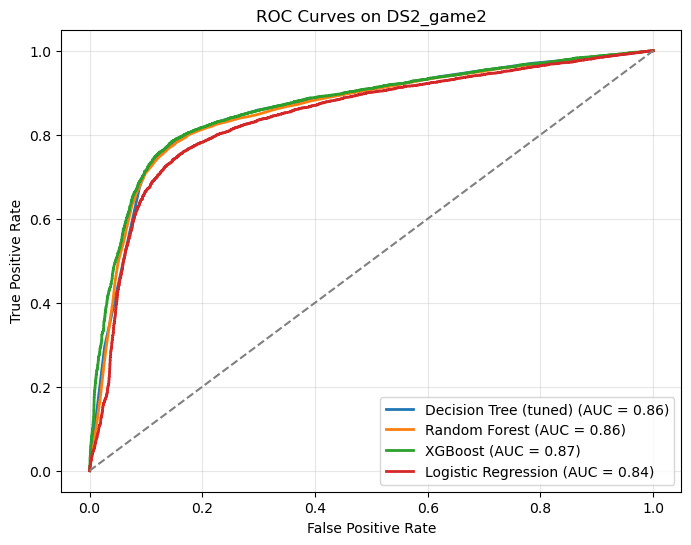

In [12]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# ── 1) LOAD DS2 FOR GAME 2 ────────────────────────────────────────────────────
df_eval = pd.read_csv('DS2_game2.csv')
X_eval  = df_eval.drop(['uid', 'churn'], axis=1)
y_eval  = df_eval['churn']

# ── 2) LOAD YOUR SAVED GAME-2 MODELS ─────────────────────────────────────────
models = {
    'Decision Tree (tuned)' : joblib.load('game2_decision_tree_tuned_model.pkl'),
    'Random Forest'         : joblib.load('game2_random_forest_model.pkl'),
    'XGBoost'               : joblib.load('game2_xgboost_model.pkl'),
    'Logistic Regression'   : joblib.load('game2_logistic_regression_model.pkl')
}

# ── 3) EVALUATE ON DS2_game2 ──────────────────────────────────────────────────
results = []
for name, model in models.items():
    y_pred = model.predict(X_eval)
    if hasattr(model, 'predict_proba'):
        y_proba   = model.predict_proba(X_eval)[:,1]
        auc_score = roc_auc_score(y_eval, y_proba)
    else:
        y_proba, auc_score = None, None

    rpt = classification_report(y_eval, y_pred, output_dict=True)
    results.append({
        'Model'       : name,
        'Accuracy'    : rpt['accuracy'],
        'Precision(1)': rpt['1']['precision'],
        'Recall(1)'   : rpt['1']['recall'],
        'F1(1)'       : rpt['1']['f1-score'],
        'ROC-AUC'     : auc_score
    })

perf_df = pd.DataFrame(results).set_index('Model')
print("### Performance on DS2_game2 ###")
print(perf_df)

# ── 4) TOP-5 FEATURE IMPORTANCES ──────────────────────────────────────────────
print("\n### Top 5 Features per Model ###")
for name, model in models.items():
    print(f"\n{name}:")
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_[0])
    fi = pd.Series(importances, index=X_eval.columns) \
           .sort_values(ascending=False) \
           .head(5)
    print(fi.to_string())

# ── 4.1) TOP-5 FEATURES BY |Pearson r| WITH CHURN ─────────────────────────────
print("\n### Top 5 Features by |Pearson r| with churn ###")
# drop the non-numeric uid column, then compute
corrs = df_eval.drop(columns=['uid']).corr(numeric_only=True)['churn'] \
               .abs() \
               .sort_values(ascending=False)
# skip the self-correlation at index 0
top5_corr = corrs.iloc[1:6]
print(top5_corr.to_string())

# ── 5) PLOT ROC CURVES FOR GAME 2 ─────────────────────────────────────────────
plt.figure(figsize=(8,6))
for name, model in models.items():
    if not hasattr(model, 'predict_proba'):
        continue
    probs     = model.predict_proba(X_eval)[:,1]
    fpr, tpr, _ = roc_curve(y_eval, probs)
    roc_auc    = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# random-chance diagonal
plt.plot([0,1], [0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on DS2_game2')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
